# Manifold reconstruction of mice hippocampus

In [81]:
import numpy as np
import mne
import os
from scipy import signal
from scipy.signal import hilbert, butter, filtfilt, spectrogram
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from matplotlib.ticker import ScalarFormatter
from statsmodels.tsa.stattools import acf
import matplotlib.pyplot as plt

from stochastic_dynamics.models import AR
from stochastic_dynamics.embedders import embed
from stochastic_dynamics.pub_utils import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

set_pub_style()

In [82]:
def bandpass_filter(x, Fs, low, high, order=4):
    wn = [low/(Fs/2), high/(Fs/2)]
    sos = signal.butter(order, wn, btype='bandpass', output='sos')
    return signal.sosfiltfilt(sos, x)

def envelope_normalize(x, fs, fband=(15, 30), env_lp_hz=5.0, eps=1e-6):
    b, a = signal.butter(4, np.array(fband)/(fs/2), btype='bandpass')
    x_bp = signal.filtfilt(b, a, x)
    z = hilbert(x_bp)
    A = np.abs(z)
    if env_lp_hz is not None:
        b_lp, a_lp = signal.butter(2, env_lp_hz/(fs/2), btype='low')
        A = signal.filtfilt(b_lp, a_lp, A)
    x_flat = x_bp / (A + eps)
    x_flat *= np.median(A)
    return x_flat, x_bp, A

def process_signal(LFP, chan, Fs, time_window, 
                   notch_freq=50, notch_Q=30,
                   bandpass_low=80, bandpass_high=140,
                   fband=(1, 80), env_lp_hz=3.0,
                   target_Fs=500):
    """Process LFP signal with notch filter, bandpass, envelope normalization, and downsampling."""
    filtered = signal.filtfilt(*signal.iirnotch(notch_freq, notch_Q, Fs), LFP[time_window, chan])
    x = np.asarray(filtered).ravel()
    xs_raw = bandpass_filter(x, Fs, low=bandpass_low, high=bandpass_high)
    
    # Downsample if needed (before envelope normalization for efficiency)
    if Fs > target_Fs:
        r = int(np.floor(Fs / target_Fs))
        xs_raw = signal.decimate(xs_raw, r, ftype='iir', zero_phase=True).astype(float)
        Fs_out = Fs / r
    else:
        Fs_out = Fs
    
    xs, _, _ = envelope_normalize(xs_raw, Fs_out, fband=fband, env_lp_hz=env_lp_hz)
    return xs, xs_raw, Fs_out


def fit_ar_model(xs, Fs, p=4, train_frac=0.9, refresh_every=10):
    X, y = AR.lag_matrix(xs, p)
    ntr = int(train_frac * len(y))
    X_tr, y_tr = X[:ntr], y[:ntr]
    w = AR.fit(X_tr, y_tr)
    N_te = len(y) - ntr
    t0 = p + ntr
    true_test = xs[t0 : t0 + N_te]
    yhat_ctrl = AR.hybrid_predict(xs, w, p, start_idx=t0, n_steps=N_te, refresh_every=refresh_every)
    full_pred = AR.hybrid_predict(xs, w, p, start_idx=p, n_steps=len(xs)-p, refresh_every=refresh_every)
    xs_pred_full = np.concatenate([xs[:p], full_pred])
    mse, mae, corr = AR.metrics(true_test, yhat_ctrl)
    return {
        'w': w, 'p': p, 'ntr': ntr, 'y': y, 'true_test': true_test,
        'yhat_ctrl': yhat_ctrl, 'xs_pred_full': xs_pred_full, 't0': t0,
        'mse': mse, 'mae': mae, 'corr': corr, 'refresh_every': refresh_every
    }

In [83]:
filename = '/Users/novak/Downloads/eke003_spont_250818_175844.npy'
channel_id = 1
raw_lfp = np.load(filename)[channel_id]
fs_original = 20000

print(f"Loaded LFP: {raw_lfp.shape} samples at {fs_original} Hz")

Loaded LFP: (10841760,) samples at 20000 Hz


In [84]:
snippet_sec = 5
time_window = np.arange(int(snippet_sec * fs_original))

# Reshape raw_lfp to (samples, channels) format for process_signal
LFP = raw_lfp.reshape(-1, 1)

xs, xs_raw, Fs = process_signal(LFP, chan=0, Fs=fs_original, time_window=time_window,
                                 bandpass_low=1, bandpass_high=20,
                                 fband=(1, 80), env_lp_hz=3.0,
                                 target_Fs=500)

time = np.arange(len(xs)) / Fs
print(f"Processed signal: {len(xs)} samples at {Fs} Hz")

Processed signal: 2500 samples at 500.0 Hz


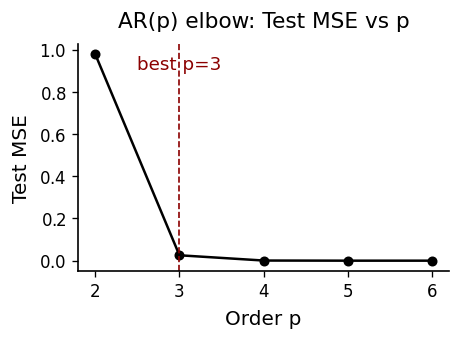

In [85]:
# Sweep AR orders for elbow plot
p_list = list(range(2, 7))
mse_te_list = []
for p in p_list:
    X, y_temp = AR.lag_matrix(xs, p)
    ntr_temp = int(0.1 * len(y_temp))
    X_tr, y_tr = X[:ntr_temp], y_temp[:ntr_temp]
    X_te, y_te = X[ntr_temp:], y_temp[ntr_temp:]
    w_temp = AR.fit(X_tr, y_tr)
    yhat_te = AR.predict_from_params(X_te, w_temp)
    mse_te, _, _ = AR.metrics(y_te, yhat_te)
    mse_te_list.append(mse_te)

best_p_by_mse = p_list[int(np.argmin(mse_te_list))]

def plot_mse_elbow(p_list, mse_list, best_p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax.plot(p_list, mse_list, marker='o', color=color_main, lw=1.5, ms=5)
    ax.axvline(best_p, linestyle='--', color=color_alt, linewidth=1)
    ax.text(best_p, ax.get_ylim()[1]*0.95, f"best p={best_p}", ha='center', va='top', color=color_alt, fontsize=11)
    sf = ScalarFormatter(useMathText=True)
    sf.set_powerlimits((-3, 3))
    ax.yaxis.set_major_formatter(sf)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-3, 3))
    ax.yaxis.get_offset_text().set_size(10)
    prettify(ax, title="AR(p) elbow: Test MSE vs p", xlabel="Order p", ylabel="Test MSE")
    plt.tight_layout()
    plt.show()

best_p_by_mse = 3

plot_mse_elbow(p_list, mse_te_list, best_p_by_mse)

In [86]:
ar_results = fit_ar_model(xs, Fs, p=3, train_frac=0.1, refresh_every=10)

w = ar_results['w']
p_use = ar_results['p']
ntr = ar_results['ntr']
y = ar_results['y']
true_test = ar_results['true_test']
yhat_ctrl = ar_results['yhat_ctrl']
xs_pred_full = ar_results['xs_pred_full']
REFRESH_EVERY = ar_results['refresh_every']

print(f"AR({p_use}): MSE={ar_results['mse']:.6f}, corr={ar_results['corr']:.3f}")

AR(3): MSE=192.180210, corr=0.990


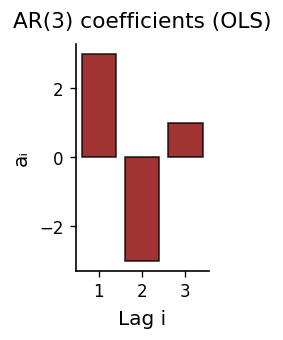

In [87]:
def plot_ar_coefficients(w, p, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(2, 3))
    ax.bar(np.arange(1, p+1), w[1:], color=color_alt, edgecolor=color_main, alpha=0.8)
    prettify(ax, title=f"AR({p}) coefficients (OLS)", xlabel="Lag i", ylabel="aᵢ")
    plt.tight_layout()
    plt.show()

plot_ar_coefficients(w, p_use)

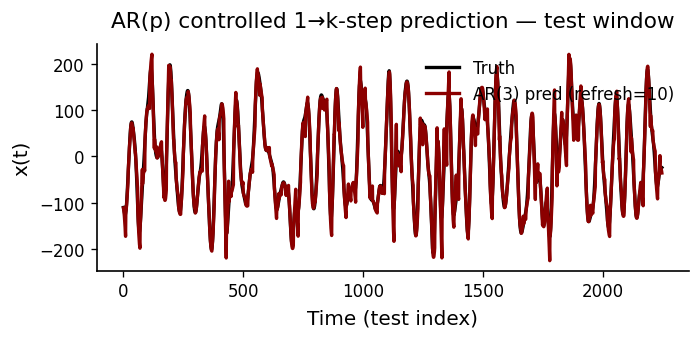

In [88]:
def plot_prediction(y_true, y_pred, p, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(6, 3))
    ax.plot(y_true + 1, color=color_main, lw=2, label="Truth")
    ax.plot(y_pred, color=color_alt, lw=2, label=f"AR({p}) pred (refresh={refresh})")
    prettify(ax, title="AR(p) controlled 1→k-step prediction — test window",
             xlabel="Time (test index)", ylabel="x(t)", add_legend=True)
    plt.tight_layout()
    plt.show()

plot_prediction(y[ntr:], yhat_ctrl, p_use, REFRESH_EVERY)

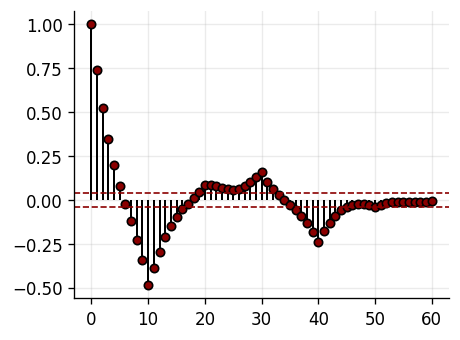

In [89]:
def plot_residual_acf(resid, nlags=60, color_main="black", color_alt="darkred"):
    acf_vals = acf(resid, nlags=nlags)
    bound = 1.96 / np.sqrt(max(len(resid), 1))
    fig, ax = plt.subplots(figsize=(4, 3))
    markerline, stemlines, baseline = ax.stem(range(len(acf_vals)), acf_vals, basefmt=" ")
    plt.setp(stemlines, color=color_main, linewidth=1.2)
    plt.setp(markerline, marker='o', markersize=5, markeredgecolor=color_main, markerfacecolor=color_alt)
    ax.axhline(bound, linestyle='--', color=color_alt, linewidth=1)
    ax.axhline(-bound, linestyle='--', color=color_alt, linewidth=1)
    plt.tight_layout()
    plt.show()

resid_te = y[ntr:] - yhat_ctrl
plot_residual_acf(resid_te)

In [90]:
REFRESH_EVERY

10

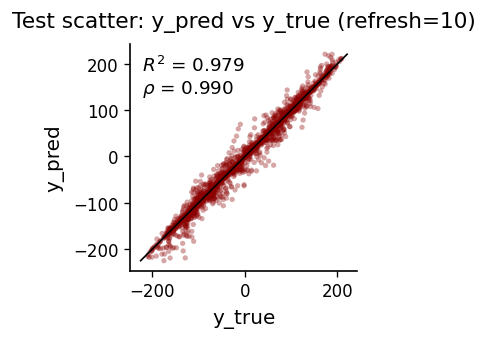

In [91]:
def plot_scatter(y_true, y_pred, refresh, color_main="black", color_alt="darkred"):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.scatter(y_true, y_pred, c=color_alt, alpha=0.35, s=10, edgecolors="none")
    vmin, vmax = min(np.min(y_true), np.min(y_pred)), max(np.max(y_true), np.max(y_pred))
    ax.plot([vmin, vmax], [vmin, vmax], color=color_main, lw=1)
    yt = y_true - np.mean(y_true)
    yp = y_pred - np.mean(y_pred)
    corr = float((yt @ yp) / np.sqrt((yt @ yt) * (yp @ yp) + 1e-12))
    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - ss_res / (ss_tot + 1e-12)
    ax.text(0.05, 0.95, f"$R^2$ = {r2:.3f}\n$\\rho$ = {corr:.3f}",
            transform=ax.transAxes, ha='left', va='top', fontsize=11,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, boxstyle="round"))
    ax.set_aspect('equal', adjustable='box')
    prettify(ax, title=f"Test scatter: y_pred vs y_true (refresh={refresh})", xlabel="y_true", ylabel="y_pred")
    plt.tight_layout()
    plt.show()

plot_scatter(y[ntr:], yhat_ctrl, REFRESH_EVERY)

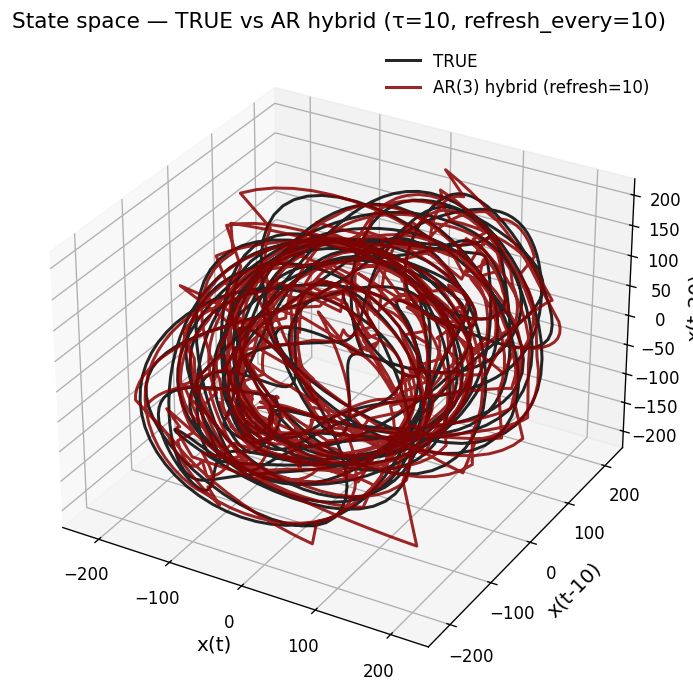

In [123]:
def plot_state_space(X3_true, X3_pred, p, tau, refresh, color_true="black", color_pred="darkred"):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(X3_true[:,0], X3_true[:,1], X3_true[:,2], label="TRUE", color=color_true, alpha=0.85)
    ax.plot(X3_pred[:,0], X3_pred[:,1], X3_pred[:,2], label=f"AR({p}) hybrid (refresh={refresh})", color=color_pred, alpha=0.85)
    ax.set_title(f"State space — TRUE vs AR hybrid (τ={tau}, refresh_every={refresh})")
    ax.set_xlabel("x(t)")
    ax.set_ylabel(f"x(t-{tau})")
    ax.set_zlabel(f"x(t-{2*tau})")
    ax.legend(frameon=False)
    plt.tight_layout()
    plt.show()

tau = 10
hy = yhat_ctrl - np.mean(yhat_ctrl)
hy = hy * (np.std(true_test) / (np.std(hy) + 1e-12)) + np.mean(true_test)

X3_true = embed(true_test, 3, tau)
X3_hyb = embed(hy, 3, tau)

plot_state_space(X3_true, X3_hyb, p_use, tau, REFRESH_EVERY)

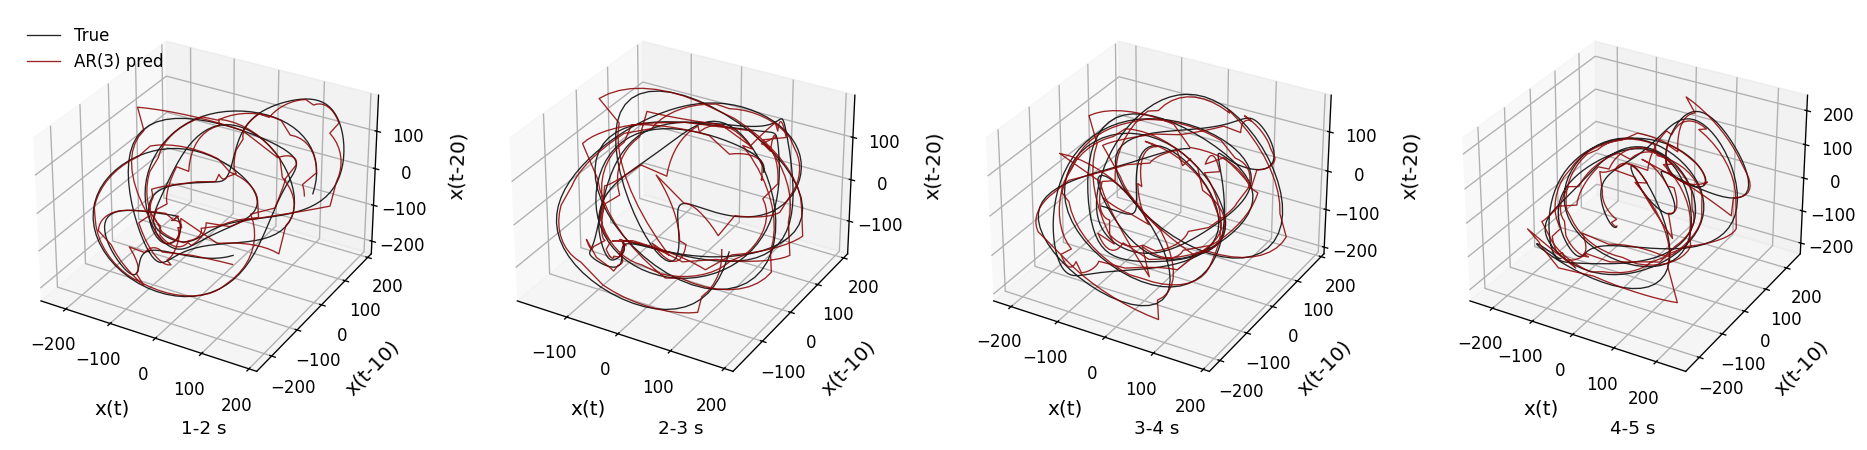

In [124]:
def plot_state_space_windows_comparison(xs, xs_pred, Fs, tau, embed_dim=3, 
                                         windows=[(1, 2), (2, 3), (3, 4), (4, 5)]):
    fig, axes = plt.subplots(1, 4, figsize=(len(windows)*4, 4), subplot_kw={'projection': '3d'})
    
    for ax, (t_start, t_end) in zip(axes, windows):
        idx_start = int(t_start * Fs)
        idx_end = int(t_end * Fs)
        
        # True signal
        segment_true = xs[idx_start:idx_end]
        X3_true = embed(segment_true, embed_dim, tau)
        
        # Predicted signal (variance-matched)
        segment_pred = xs_pred[idx_start:idx_end]
        seg_pred_matched = segment_pred - np.mean(segment_pred)
        seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
        seg_pred_matched = seg_pred_matched + np.mean(segment_true)
        X3_pred = embed(seg_pred_matched, embed_dim, tau)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label=f'AR({p_use}) pred')
        ax.set_xlabel("x(t)", labelpad=10)
        ax.set_ylabel(f"x(t-{tau})", labelpad=10)
        ax.set_zlabel(f"x(t-{2*tau})", labelpad=10)
        ax.text2D(0.5, -0.1, f"{t_start}-{t_end} s", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.15, top=0.95, wspace=0.15)
    plt.show()

# Build full prediction for visualization
full_pred = AR.hybrid_predict(xs, w, p_use, start_idx=p_use, n_steps=len(xs)-p_use, refresh_every=REFRESH_EVERY)
xs_pred_full = np.concatenate([xs[:p_use], full_pred])

plot_state_space_windows_comparison(xs, xs_pred_full, Fs, tau)

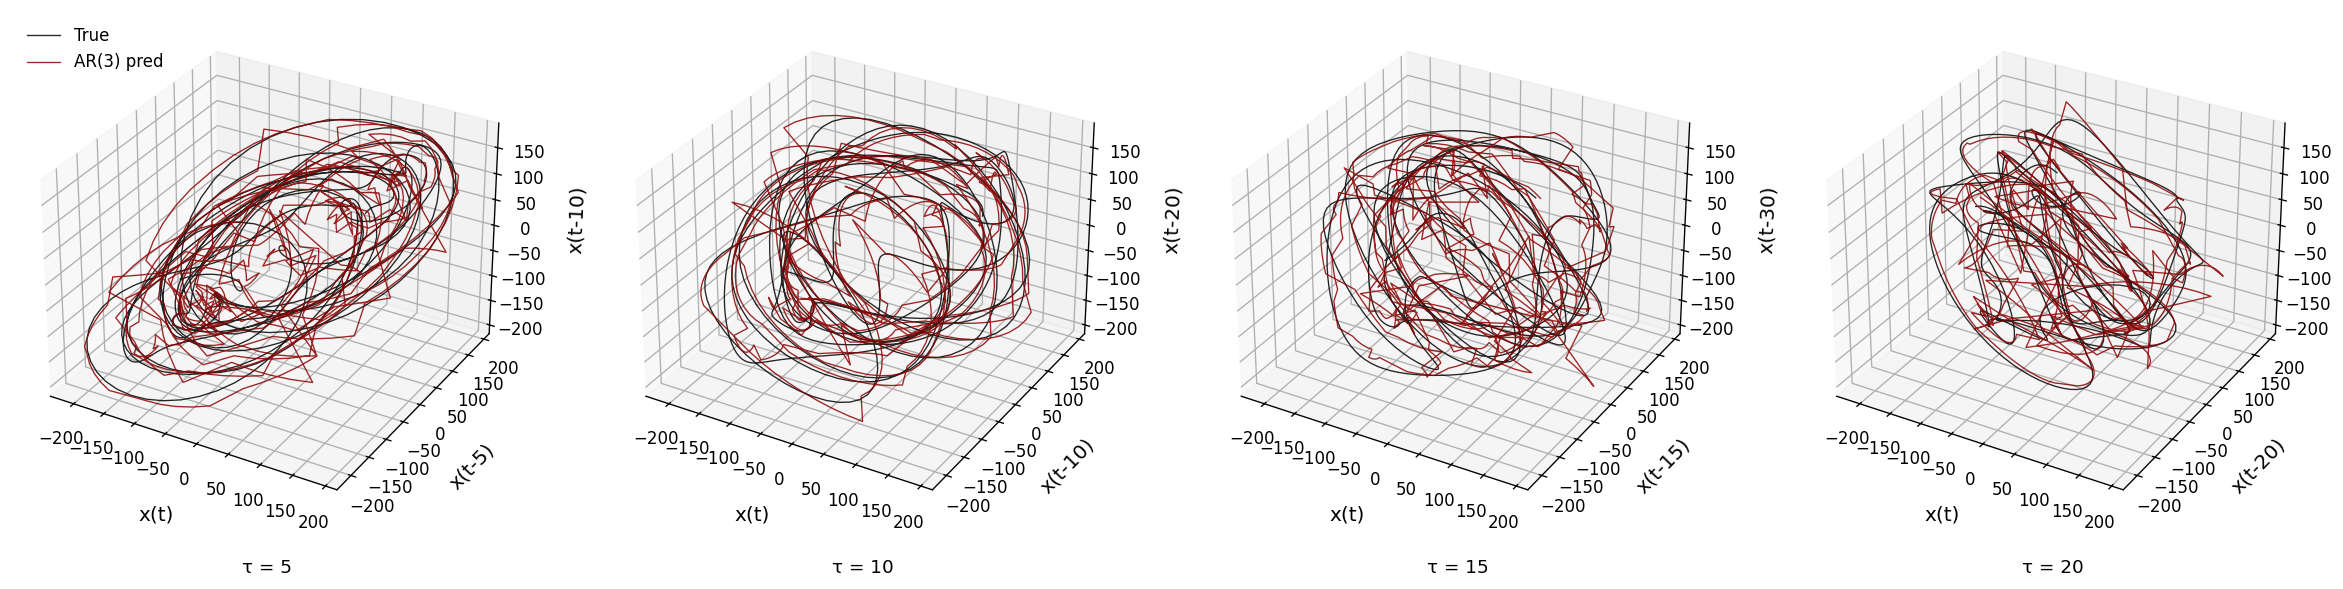

In [106]:
def plot_state_space_tau_sweep(xs, xs_pred, Fs, t_start, t_end, taus=[5, 10, 15, 20], embed_dim=3):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5), subplot_kw={'projection': '3d'})
    
    idx_start = int(t_start * Fs)
    idx_end = int(t_end * Fs)
    segment_true = xs[idx_start:idx_end]
    segment_pred = xs_pred[idx_start:idx_end]
    
    # Variance-match prediction
    seg_pred_matched = segment_pred - np.mean(segment_pred)
    seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
    seg_pred_matched = seg_pred_matched + np.mean(segment_true)
    
    for ax, tau_val in zip(axes, taus):
        X3_true = embed(segment_true, embed_dim, tau_val)
        X3_pred = embed(seg_pred_matched, embed_dim, tau_val)
        
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label=f'AR({p_use}) pred')
        ax.set_xlabel("x(t)", labelpad=10)
        ax.set_ylabel(f"x(t-{tau_val})", labelpad=10)
        ax.set_zlabel(f"x(t-{2*tau_val})", labelpad=10)
        ax.text2D(0.5, -0.1, f"τ = {tau_val}", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.95, wspace=0.15)
    plt.show()

# Use valid time window within 5 second signal
plot_state_space_tau_sweep(xs, xs_pred_full, Fs, t_start=2, t_end=4)

Full data shape: (4, 10841760)


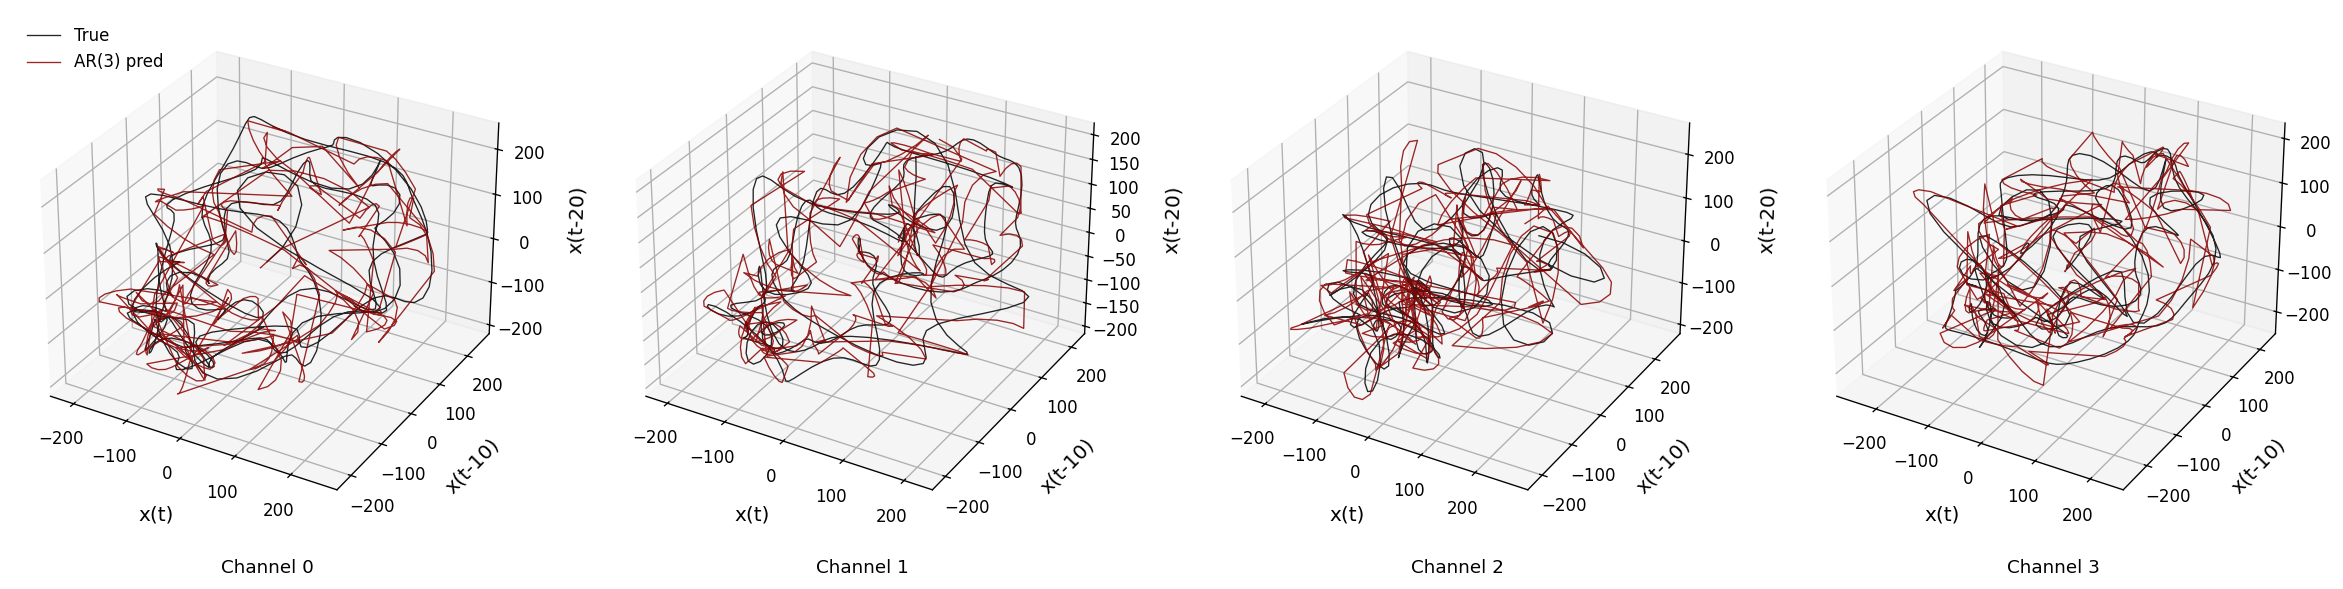

In [121]:
def sweep_channels_plot(raw_data, channels, time_windows, taus, fs_orig,
                        p=3, train_frac=0.9, refresh_every=5,
                        bandpass_low=1.0, bandpass_high=50.0, 
                        fband=(1, 80), env_lp_hz=3.0, embed_dim=3,
                        target_Fs=500):
    """
    Process multiple channels from mouse data and plot state space comparison.
    
    Parameters
    ----------
    raw_data : ndarray
        Raw LFP data with shape (channels, samples)
    channels : list of int
        Channel indices to process
    time_windows : list of tuple
        (start_sec, end_sec) for each channel's plot window
    taus : list of int
        Embedding delay for each channel
    fs_orig : float
        Original sampling frequency
    target_Fs : float
        Target sampling frequency after downsampling
    """
    n = len(channels)
    fig, axes = plt.subplots(1, n, figsize=(n*5, 5), subplot_kw={'projection': '3d'})
    if n == 1:
        axes = [axes]
    
    # Convert to (samples, channels) format
    LFP = raw_data.T
    
    for ax, chan, (t_start, t_end), tau_val in zip(axes, channels, time_windows, taus):
        # Create time window indices
        time_window = np.arange(int(t_end * fs_orig))
        
        # Process signal (now returns Fs_out)
        xs_ch, _, Fs_ch = process_signal(LFP, chan, fs_orig, time_window,
                                          bandpass_low=bandpass_low, bandpass_high=bandpass_high,
                                          fband=fband, env_lp_hz=env_lp_hz,
                                          target_Fs=target_Fs)
        
        # Fit AR model
        ar_res = fit_ar_model(xs_ch, Fs_ch, p=p, train_frac=train_frac, refresh_every=refresh_every)
        w_ch, xs_pred_ch = ar_res['w'], ar_res['xs_pred_full']
        
        # Extract window (using downsampled Fs)
        idx_start, idx_end = int(t_start * Fs_ch), int(t_end * Fs_ch)
        segment_true = xs_ch[idx_start:idx_end]
        segment_pred = xs_pred_ch[idx_start:idx_end]
        
        # Variance-match prediction
        seg_pred_matched = segment_pred - np.mean(segment_pred)
        seg_pred_matched = seg_pred_matched * (np.std(segment_true) / (np.std(seg_pred_matched) + 1e-12))
        seg_pred_matched = seg_pred_matched + np.mean(segment_true)
        
        # Embed
        X3_true = embed(segment_true, embed_dim, tau_val)
        X3_pred = embed(seg_pred_matched, embed_dim, tau_val)
        
        # Plot
        ax.plot(X3_true[:, 0], X3_true[:, 1], X3_true[:, 2], color='black', alpha=0.85, lw=0.8, label='True')
        ax.plot(X3_pred[:, 0], X3_pred[:, 1], X3_pred[:, 2], color='darkred', alpha=0.85, lw=0.8, label=f'AR({p}) pred')
        ax.set_xlabel("x(t)", labelpad=10)
        ax.set_ylabel(f"x(t-{tau_val})", labelpad=10)
        ax.set_zlabel(f"x(t-{2*tau_val})", labelpad=10)
        ax.text2D(0.5, -0.1, f"Channel {chan}", transform=ax.transAxes, ha='center', fontsize=11)
    
    axes[0].legend(frameon=False, loc='upper left')
    fig.subplots_adjust(left=0.02, right=0.98, bottom=0.1, top=0.95, wspace=0.15)
    plt.show()

# Load full raw data for multi-channel sweep
raw_data_full = np.load(filename)
print(f"Full data shape: {raw_data_full.shape}")

# Sweep across channels (using valid channels and time windows)
sweep_channels_plot(
    raw_data_full, 
    channels=[0, 1, 2, 3],
    time_windows=[(5, 6), (6, 7), (8, 9), (10, 11)],
    taus=[10, 10, 10, 10],
    fs_orig=fs_original,
    target_Fs=500
)